# RNN For Time series
The objective of this study is to use Recurant Neural Networks to predict TimeSeries.                                            
Authors : Hamza BOUKRAICHI and Loic CORDONE

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib

import matplotlib.pyplot as plt

SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

T = 20
L = 1000
N = 100

# Generate Training Data

In [2]:
x = np.empty((N, L), 'int32')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float32')

# load data and make training set
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
print (input.shape)
print (target.shape)

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
print (test_input.shape)
print (test_target.shape)

torch.Size([97, 999])
torch.Size([97, 999])
torch.Size([3, 999])
torch.Size([3, 999])


# Model

In [3]:
class Sequence(nn.Module):
    def __init__(self, hdim):
        super(Sequence, self).__init__()
        self.rnn = nn.GRUCell(1, hdim)
        self.linear = nn.Linear(hdim, 1)
        self.hdim = hdim

    def forward(self, input, future = 0):
        outputs = []
        
        # create a tensor for the hidden state initialized to zero
        h_t = torch.zeros((input.size(0),self.hdim))

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            # apply the RNN
            h_t = self.rnn(input_t,h_t)
            # apply the linear layer 
            output = self.linear(h_t)
            outputs.append(output)
        for i in range(future):# if we should predict the future
            
            # apply the RNN to the last value
            h_t =  self.rnn(output,h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [4]:
# build the model with 10 hidden units
seq = Sequence(10)

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# TRAIN AND TEST

STEP: 0 loss: 0.00017941478290595114 test loss: 0.00015886004257481545


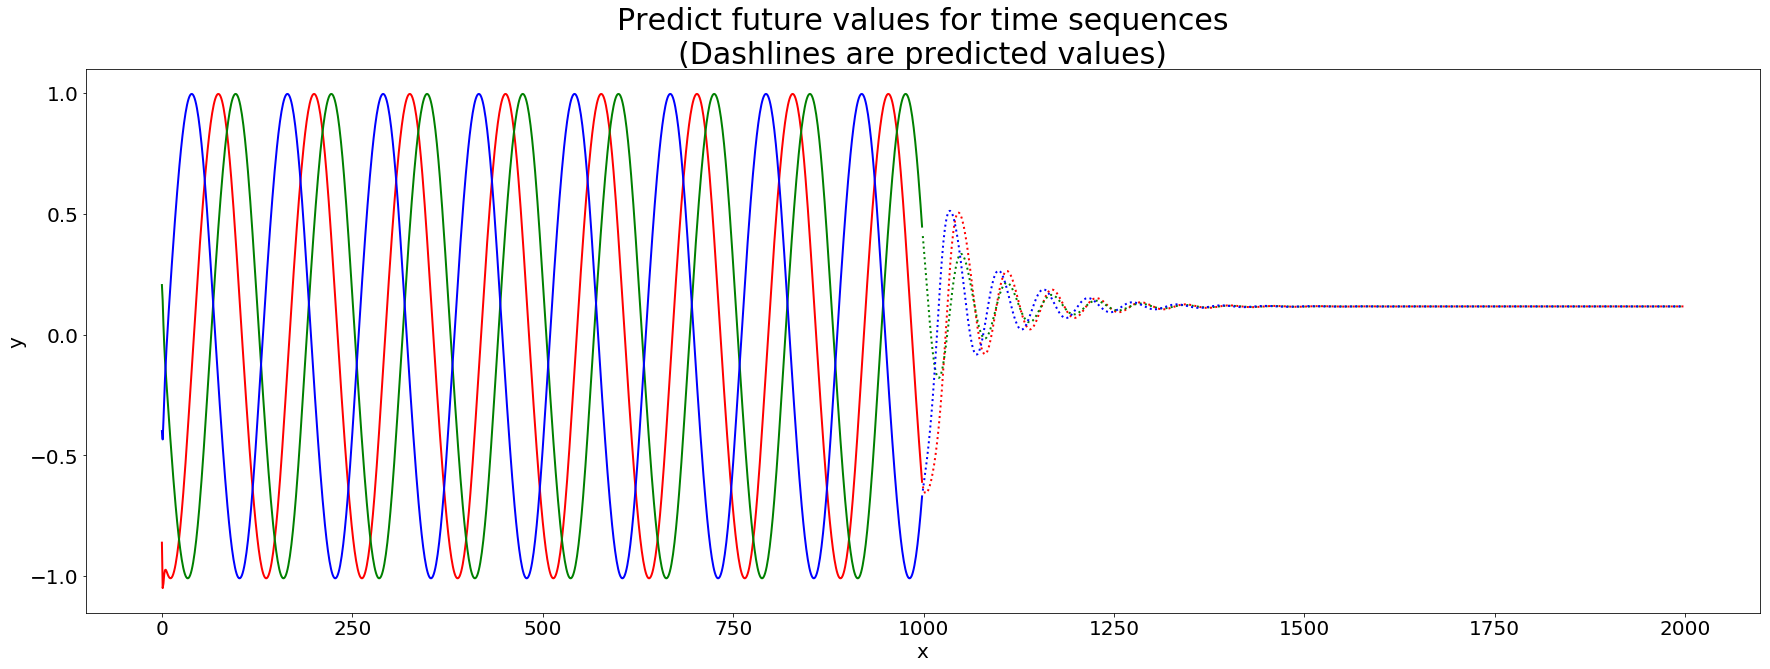

STEP: 1 loss: 8.122010331135243e-058 test loss: 8.502748096361756e-05


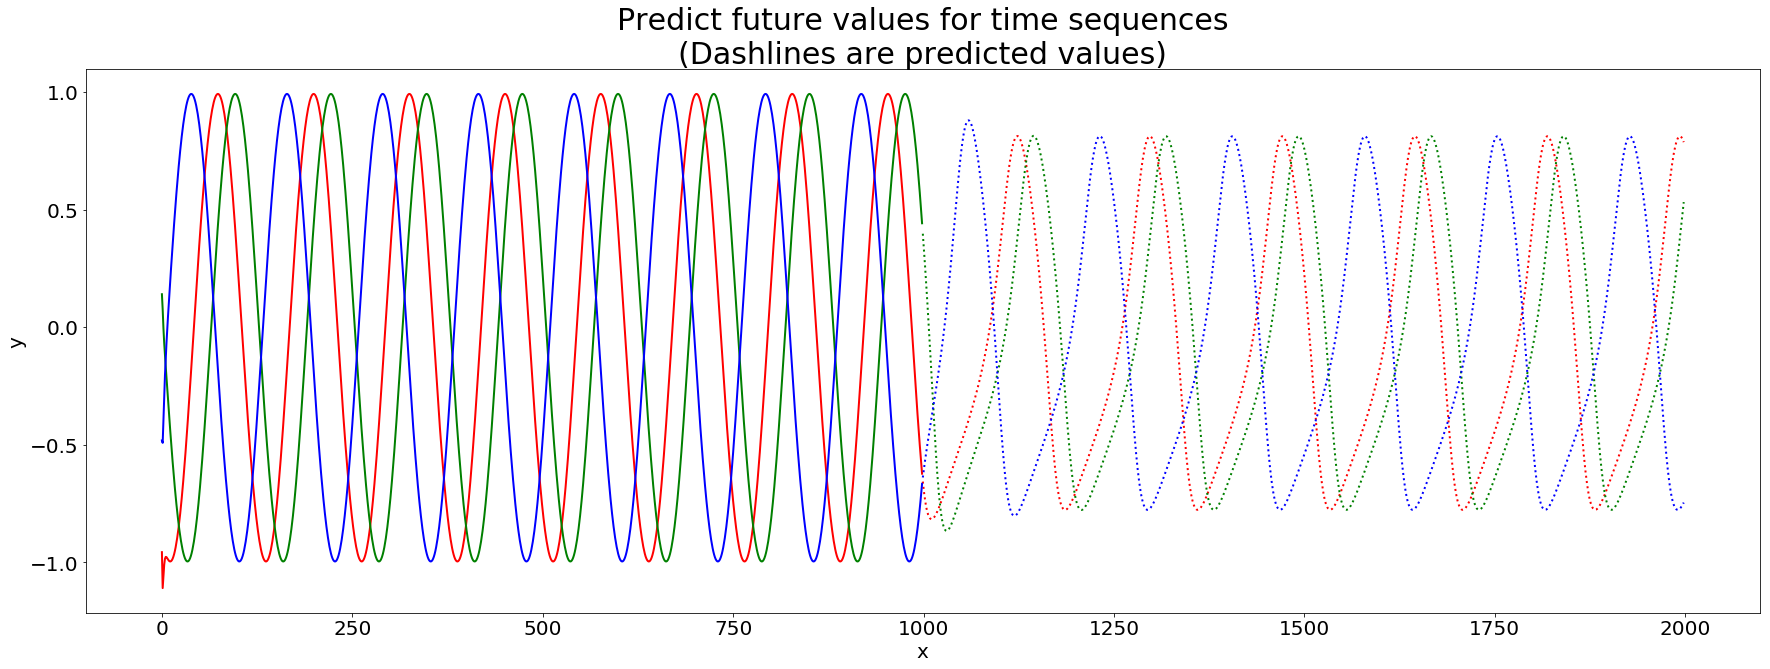

STEP: 2 loss: 6.859005225123838e-05 test loss: 6.721397221554071e-05


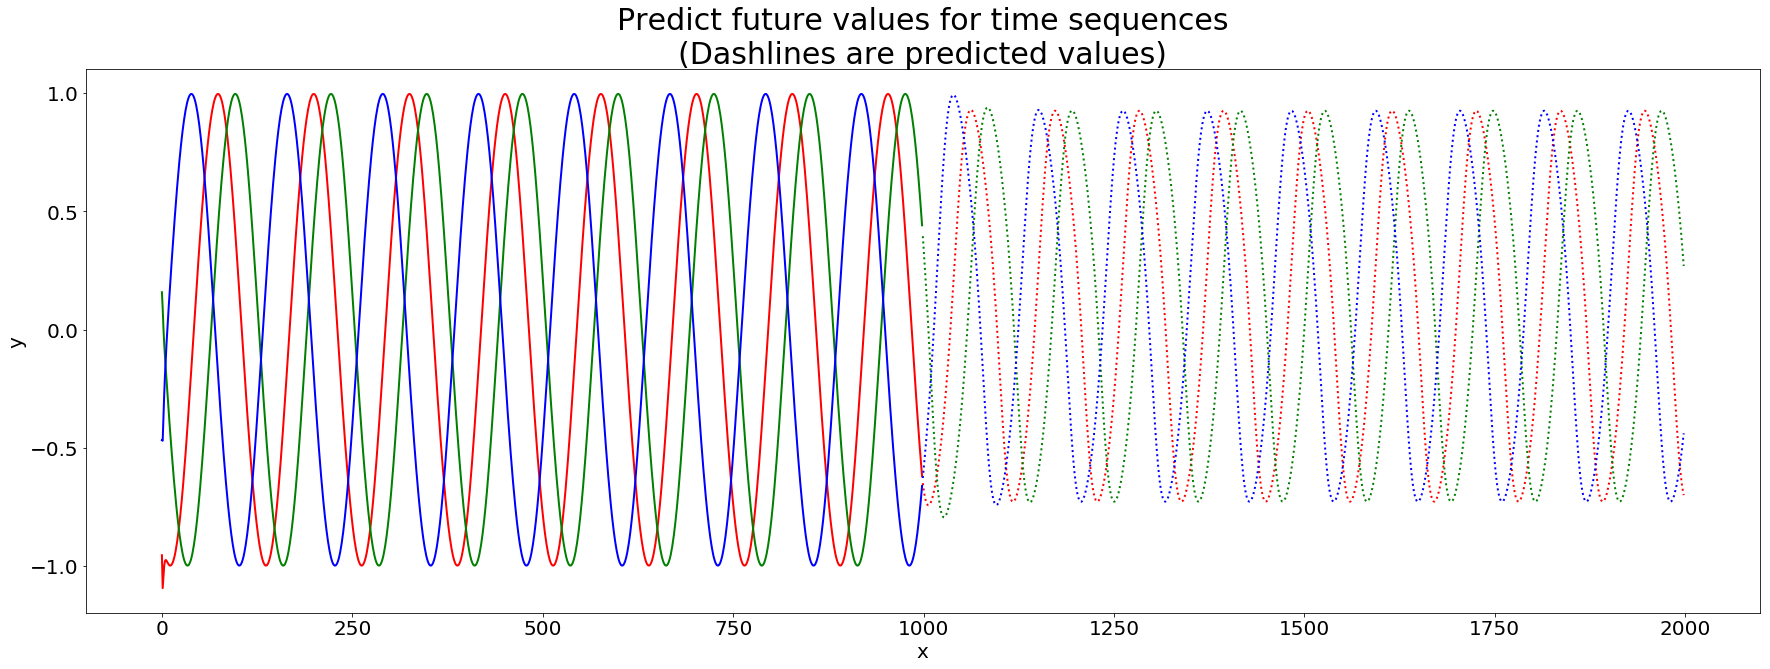

STEP: 3 loss: 3.769520117202774e-055 test loss: 4.2137438867939636e-05


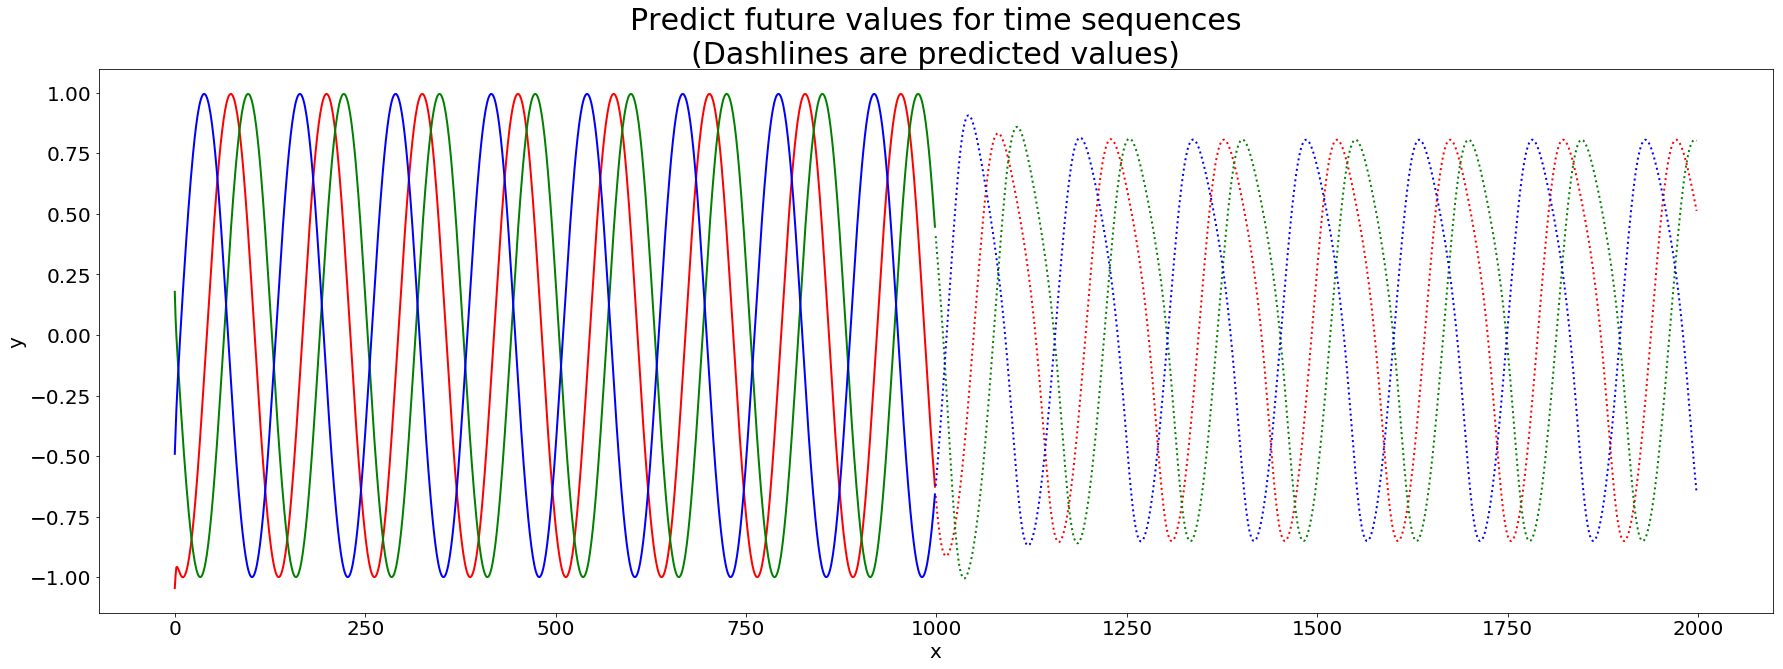

STEP: 4 loss: 2.4923961973399855e-05 test loss: 2.727721403061878e-05


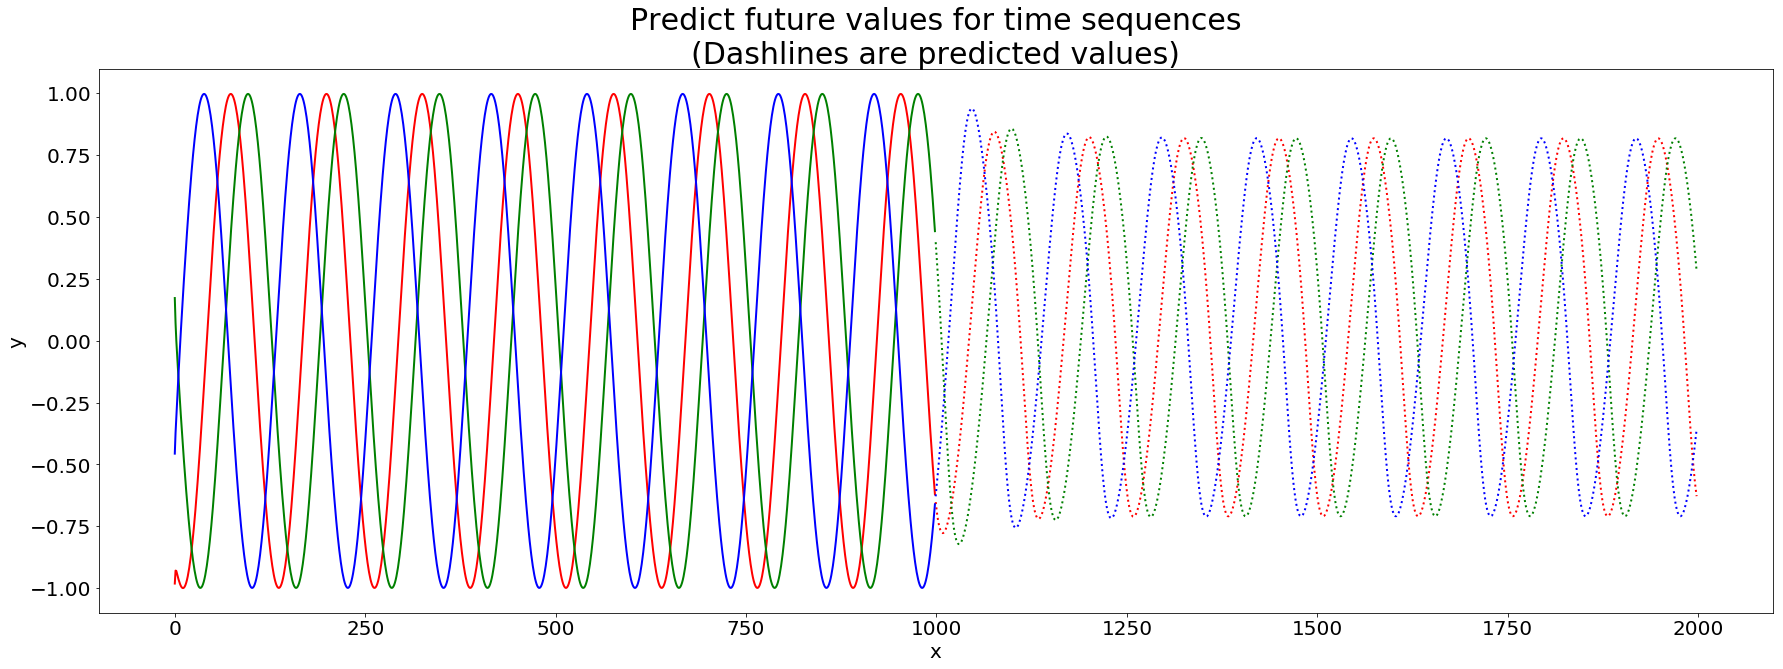

STEP: 5 loss: 1.4785302482778206e-05 test loss: 1.5138488379307091e-05


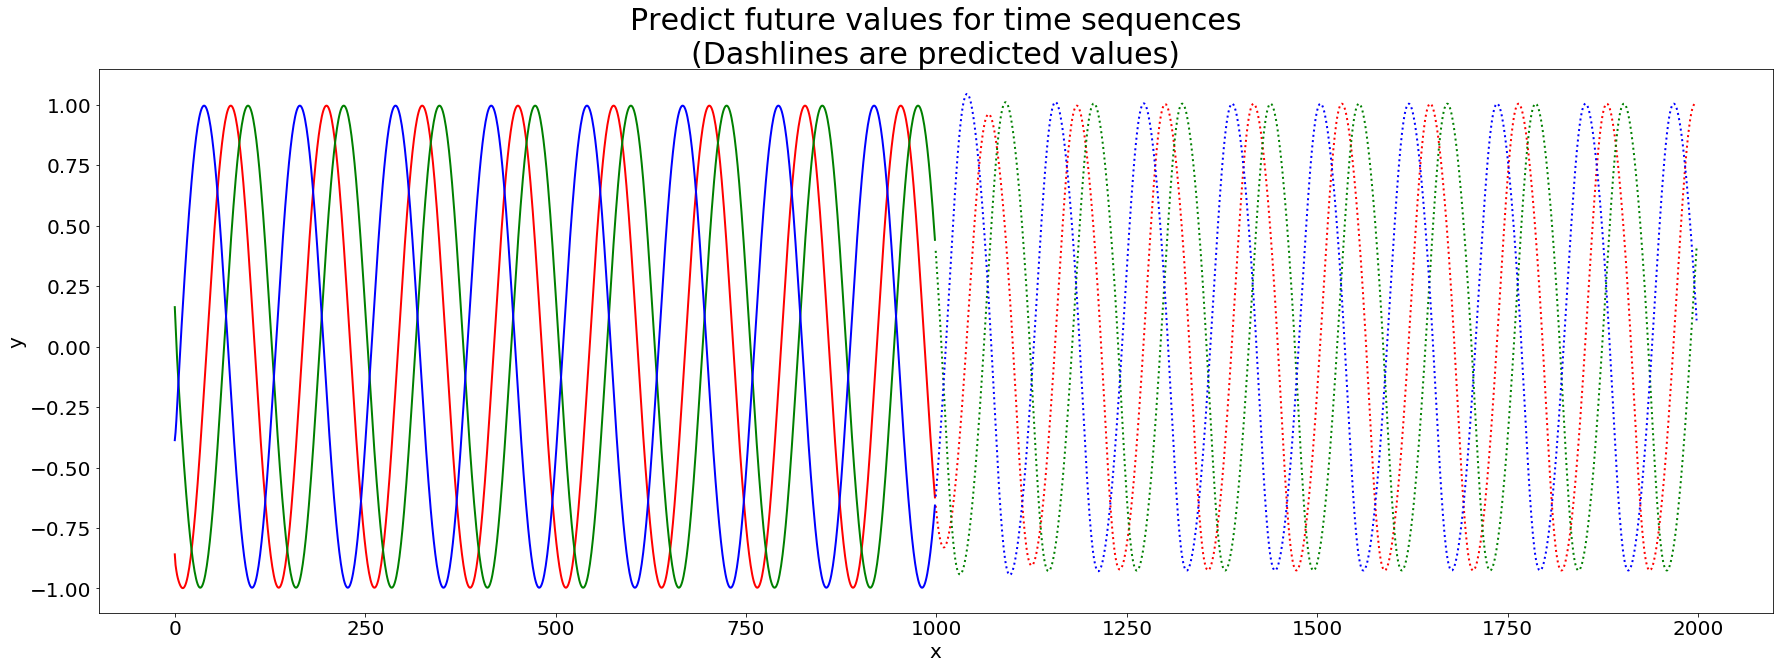

STEP: 6 loss: 1.0822559488588013e-05 test loss: 1.0812586879183073e-05


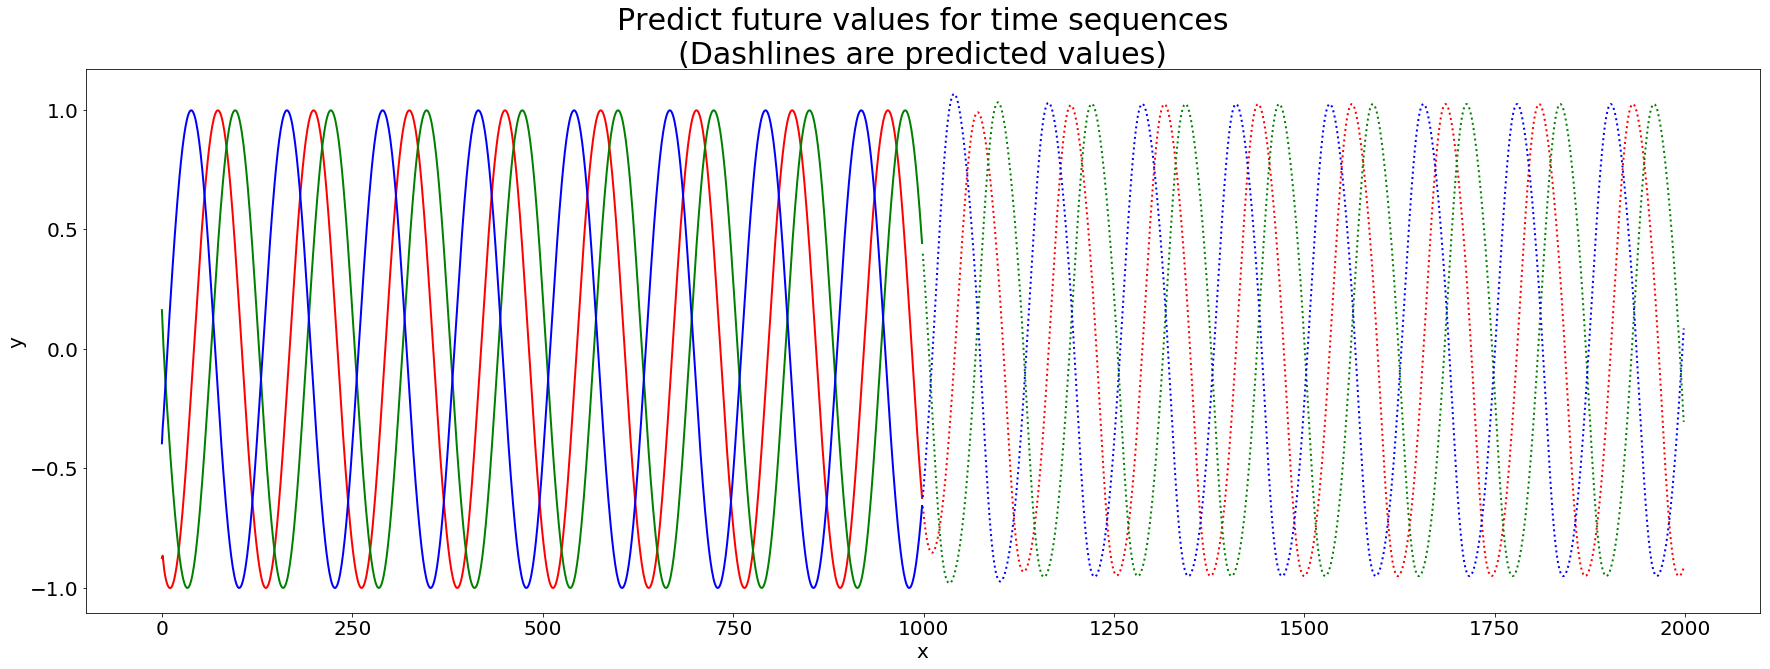

STEP: 7 loss: 7.95101914263796e-0665 test loss: 7.876718882471323e-06


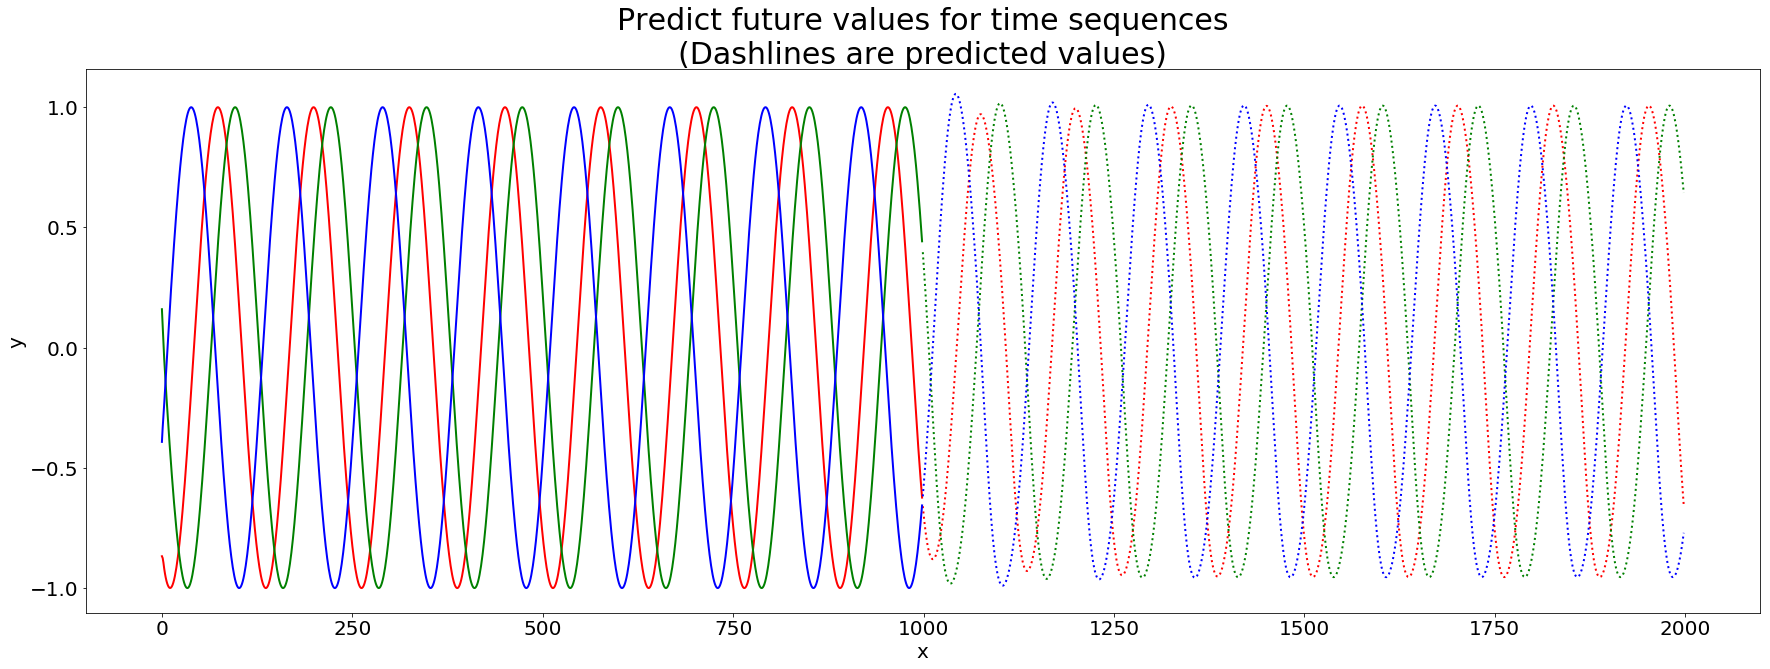

STEP: 8 loss: 6.277824923017761e-06 test loss: 6.580624358321074e-06


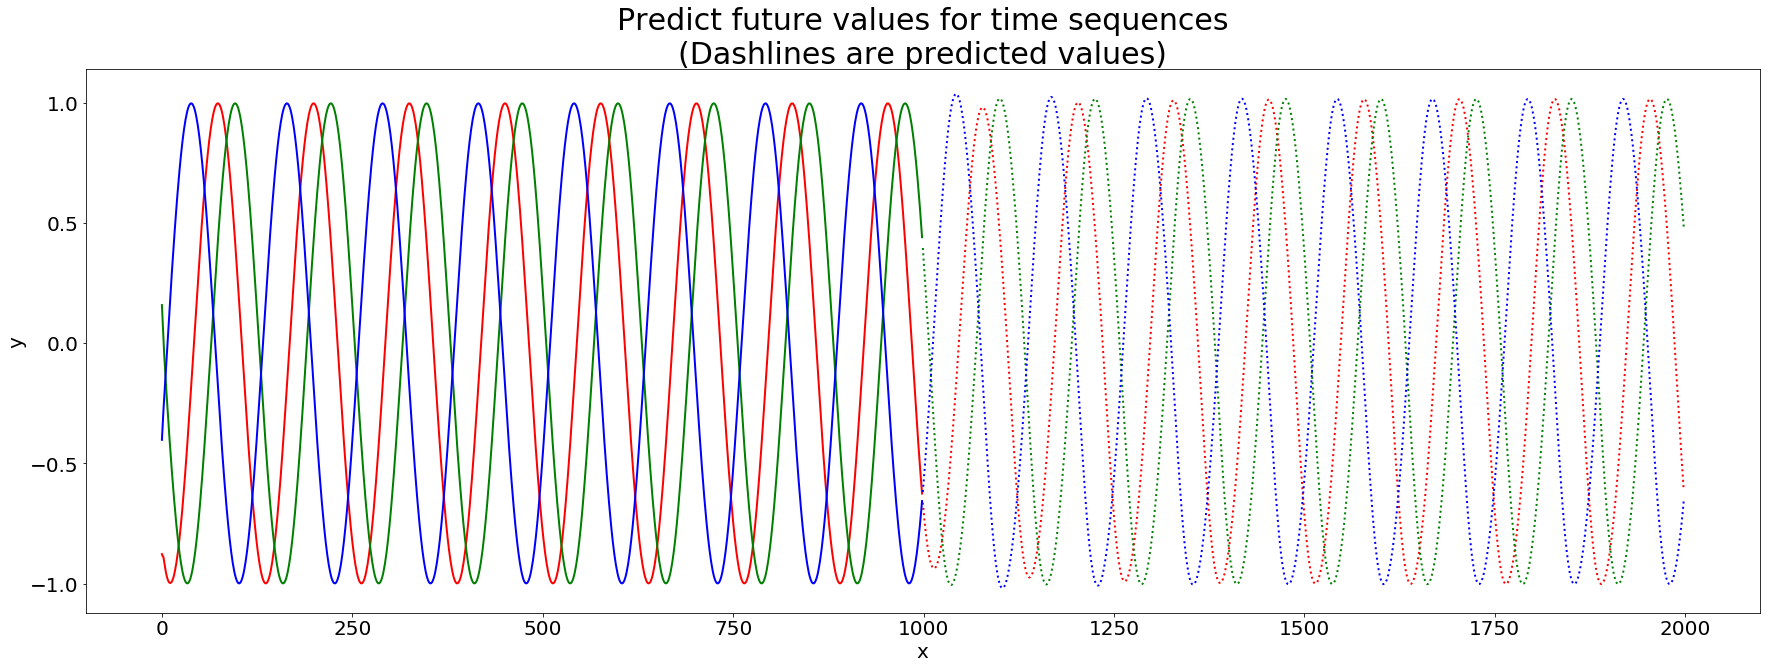

STEP: 9 loss: 6.073286840546643e-066 test loss: 6.420669251383515e-06


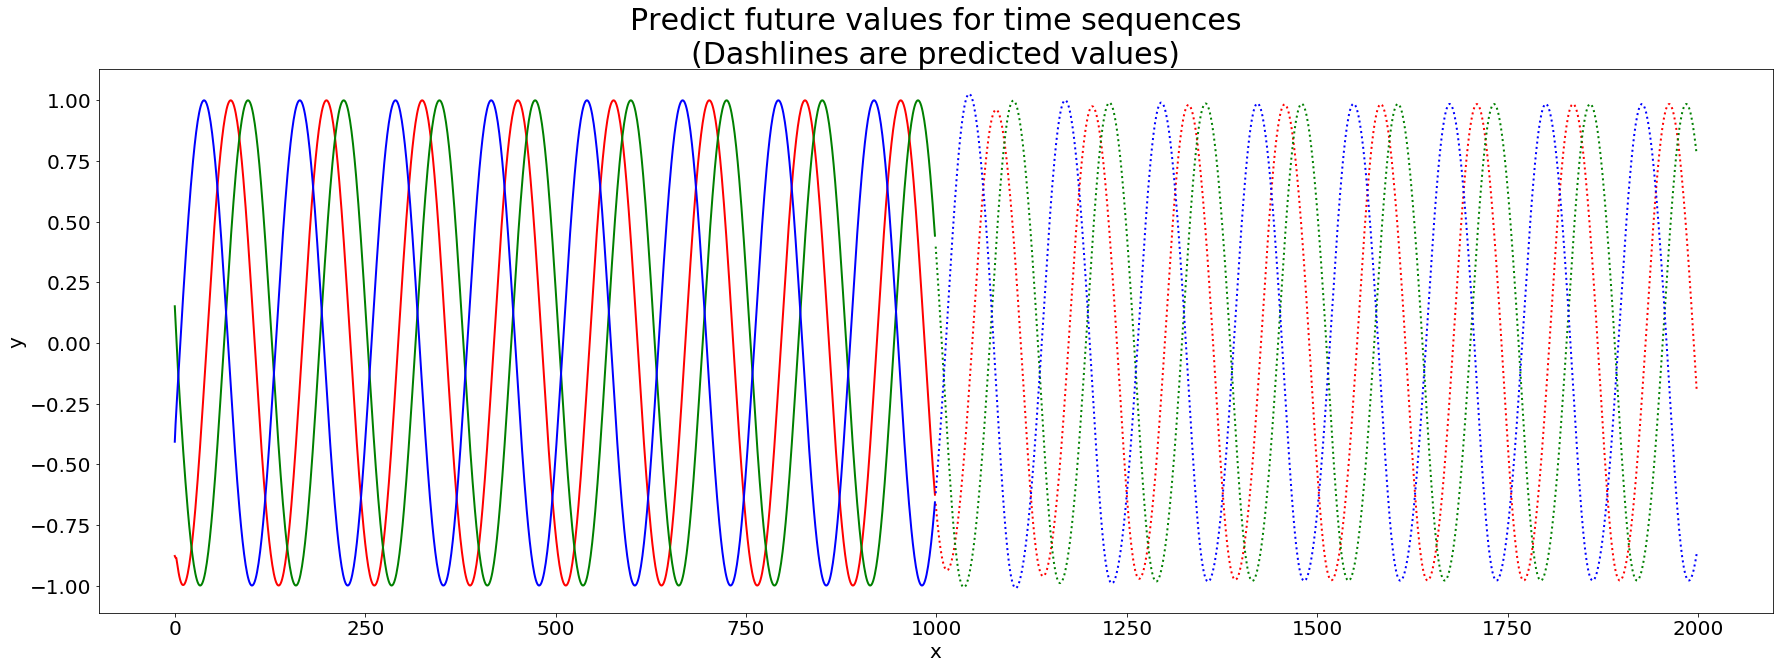

STEP: 10 loss: 6.071273219276918e-06 test loss: 6.412622042262228e-06


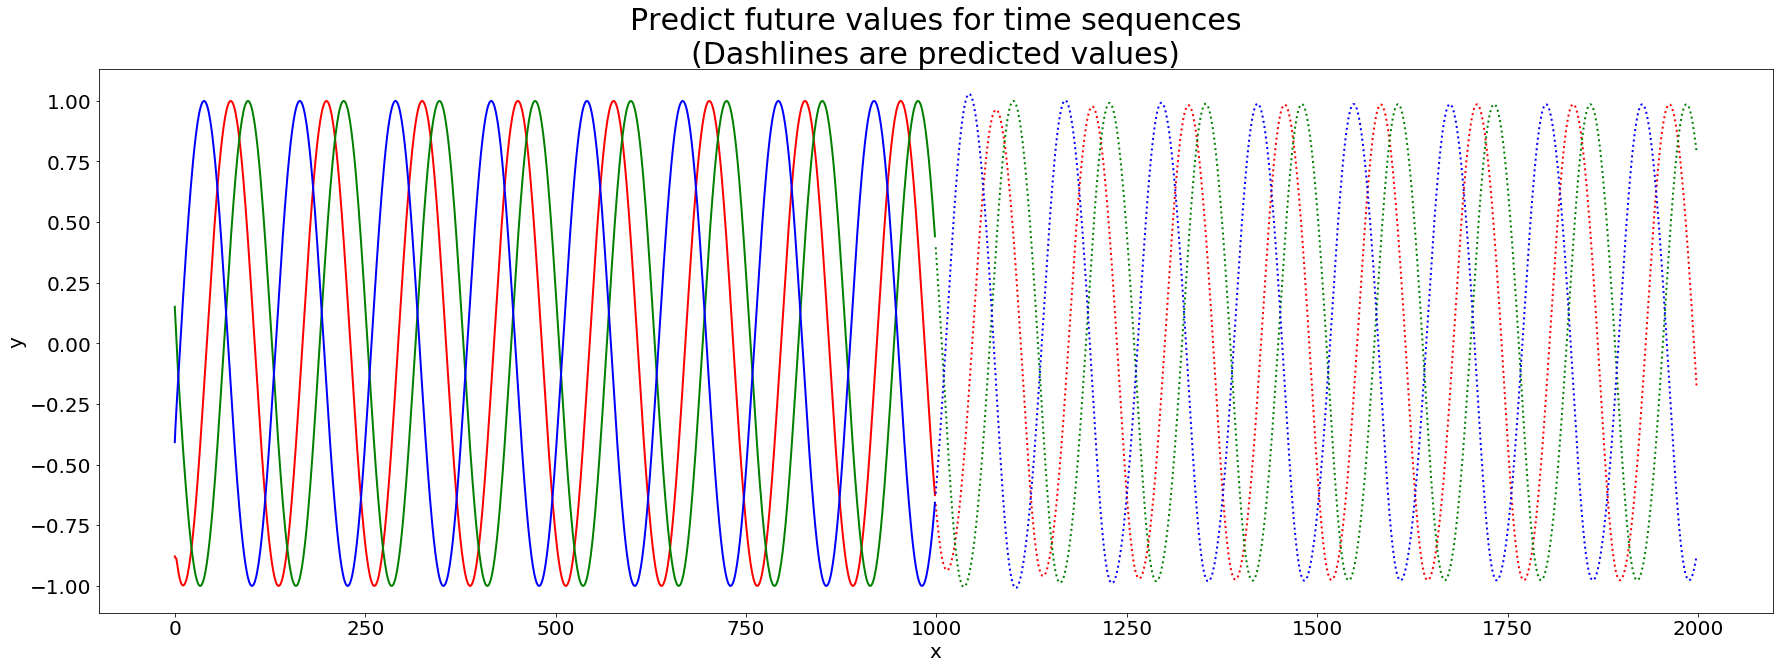

STEP: 11 loss: 5.755978236265946e-066 test loss: 6.167447736515896e-06


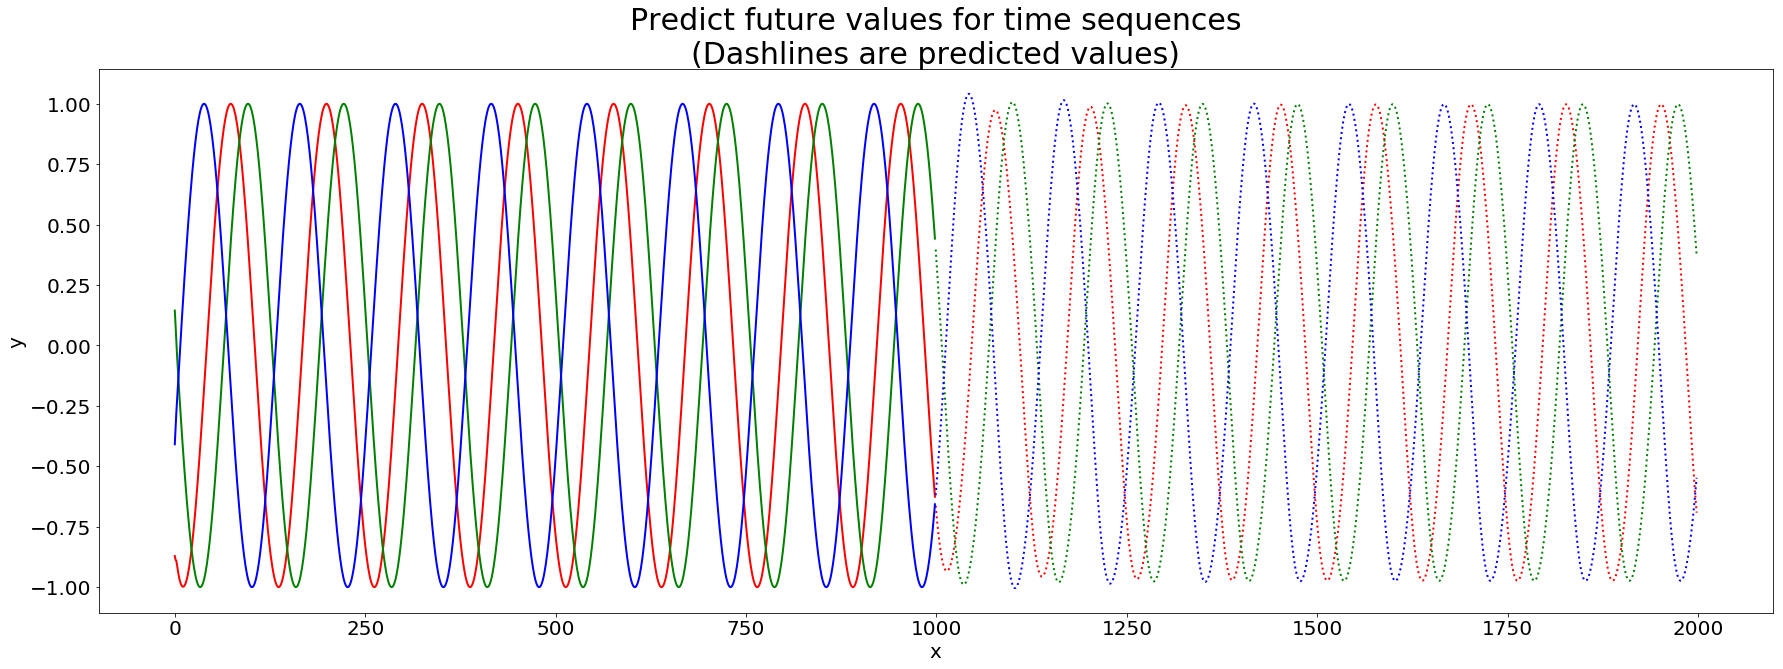

STEP: 12 loss: 5.257260454527568e-066 test loss: 6.1957889556651935e-06


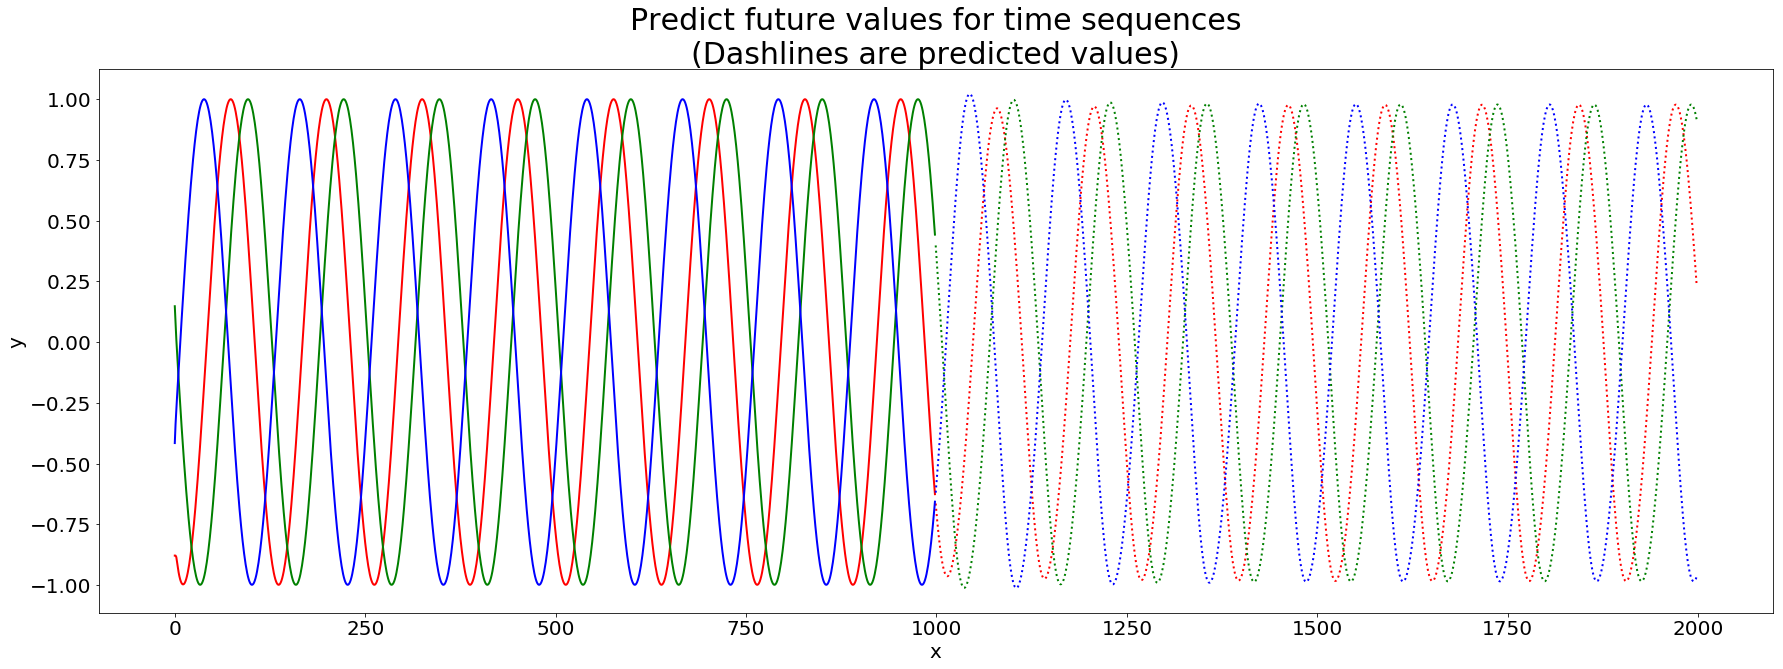

STEP: 13 loss: 4.6991058297862764e-06 test loss: 5.5054201766324695e-06


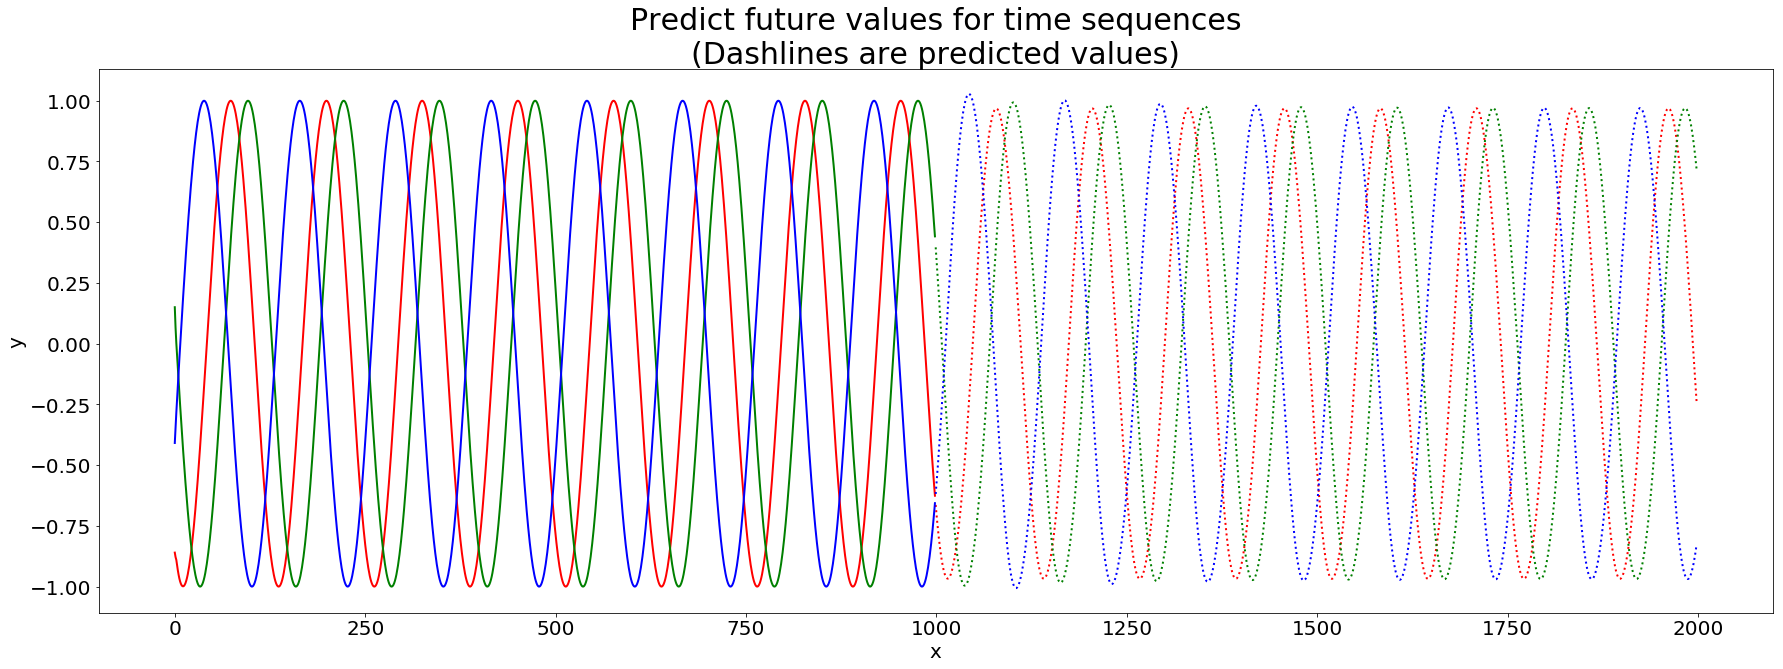

STEP: 14 loss: 4.283565431251191e-066 test loss: 5.403805971582187e-06


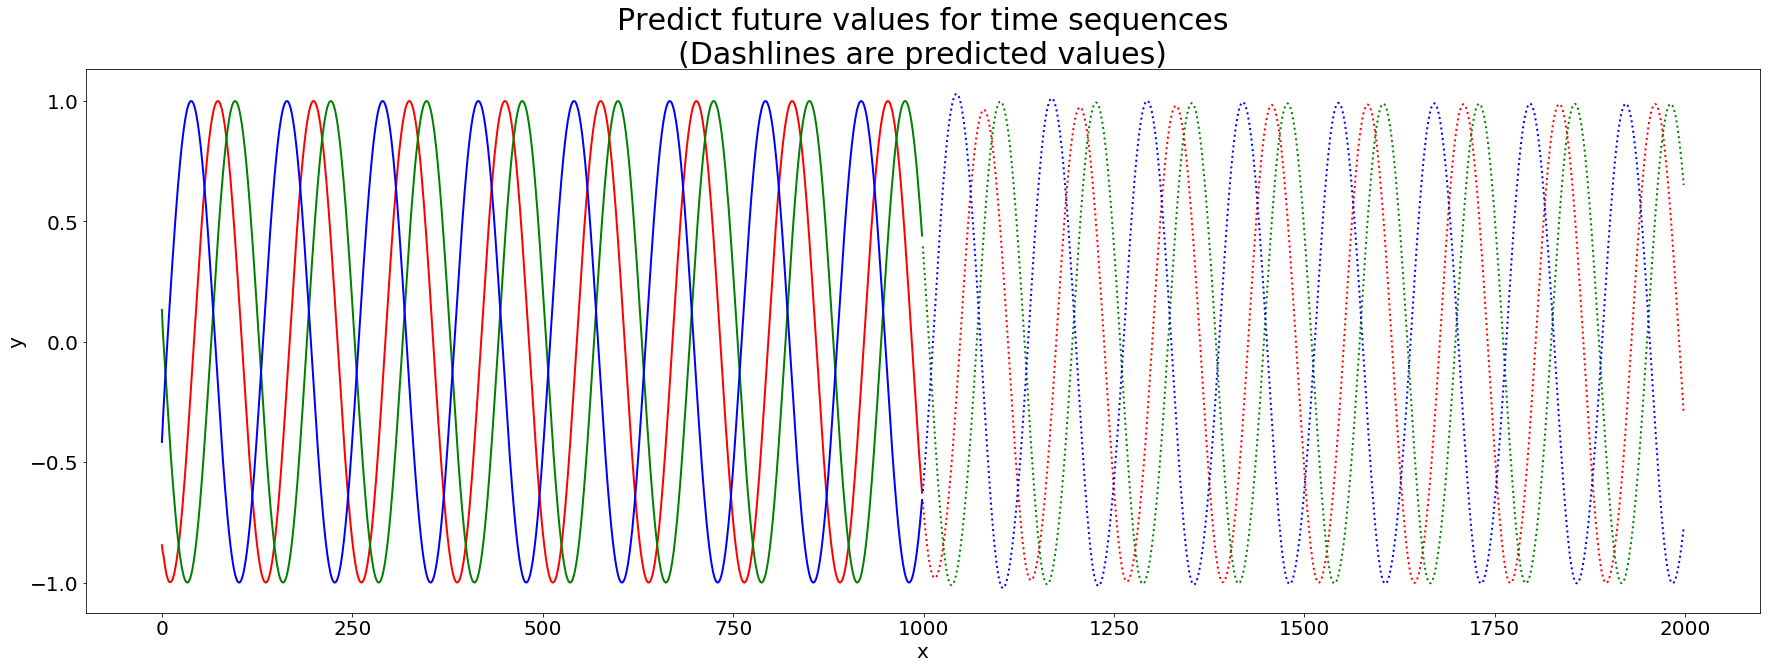

In [5]:
#begin to train
for i in range(15):
    
    
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('\rSTEP:', i,'loss:', loss.item(), end='')
        loss.backward()
        return loss
    optimizer.step(closure)
    
    future = 1000
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()
    #plt.close()